# Titanic Passenger Dataset Analysis
### Udacity Data Science Nanodegree Project 2
**Zach Dischner**

**Feb 20 2017**

## Background
This project will feature an exploratory analysis of the Titanic dataset made available by Kaggle: https://www.kaggle.com/c/titanic/data

I will pose questions that I hope to answer with the included dataset, wrangle Titanic data into something more useable for analysis, and perform said analysis. The goal is to answer questions with statistics, figures, and visualizations.

### 1. Load Dataset 

In [447]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib.mlab import find
from pandas.tools.plotting import scatter_matrix
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

matplotlib.rcParams['figure.figsize'] = (18.0, 4.0)


fname = "titanic-data.csv"
df = pd.read_csv(fname)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2. Data Wrangling
Wrangling the Titanic data will be relatively straightforward. It is provided in a single CSV file, where each row represents a passenger on board the ship, and columns are attributes of said passengers. Along with a unique passenger ID, attributes include ticket class, sex, name, whether or not they survived, age, number of family members on board, fare, cabin assignment, and where they embarked from. 

#### Notables
* The **Age**, **Cabin** and **Embarked** columns contain null values. Specifically, **77% of the Cabin columm is comprised of NaNs**
* In addition, there are 25 passengers whose ages were given but only estimated.
* **Pclass** and **Survived** columns are numeric in nature, but their values are actually enumerations. 
  * **Pclass**: 1==>1st class, 2==>2nd class, 3==>3rd class socioeconomic status (SES)
  * **Survived**: Boolean, 0==>Perished, 1==>Survived
* **Age** and **Fare** are true floating points, while **SibSp** and **Parch** are integer counts of related family members on board, and cannot have non-integer values. These types have been correctly interpretred by `pandas` and do not need further wrangling. 
* **Fare** is provided as a floating point value, however there are a number of 0.0 fares in the dataset. 0.0 fares occur for all class passengers. It is unknown if this is a result of free/won tickets, the fact that the fare was not actually known, or some other explanation. Fare based explorations will have to account for this price behavior. 
* **Age** of passengers ranges from newborn (estimated) to 80 years old for the oldest passengers. With the mean and median passenger age in the late 20s, between 28 and 29 years old. 

#### Wrangle
Specific explorations can perform a bit of further manipulation and re-organization. The job here is to make sure that the data is ready for further analysis by isolating and identifying missing values, ensure that data values fall within sensible ranges and are typed sensibly. As a baseline, I'll fix up the base dataset with the following operations: 
0. Convert columns to lowercase (avoid confusion with camelcase, etc)
0. Isolate lastname (family name) for each passenger, create a new attribute per-passenger with it
0. Sum up immediate family members, create a new attribute per-passenger with it
0. Replace NaN Cabin assignments with "Unknown"
0. Replace NaN Age assignments with -1
0. Manually reorder columns to group associated familial information together

Raw Titanic Data Summary Information
              missing_count  missing_percent    dtype  count        mean  \
PassengerId              0         0.000000    int64  891.0  446.000000   
Survived                 0         0.000000    int64  891.0    0.383838   
Pclass                   0         0.000000    int64  891.0    2.308642   
Name                     0         0.000000   object    NaN         NaN   
Sex                      0         0.000000   object    NaN         NaN   
Age                    177        19.865320  float64  714.0   29.699118   
SibSp                    0         0.000000    int64  891.0    0.523008   
Parch                    0         0.000000    int64  891.0    0.381594   
Ticket                   0         0.000000   object    NaN         NaN   
Fare                     0         0.000000  float64  891.0   32.204208   
Cabin                  687        77.104377   object    NaN         NaN   
Embarked                 2         0.224467   object    NaN   

/Users/dischnerz/anaconda3/envs/bleeding/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,passengerid,survived,pclass,famname,famcount,sibsp,parch,name,sex,age,ticket,fare,cabin,embarked
0,1,0,3,Braund,1,1,0,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,Unknown,S
1,2,1,1,Cumings,1,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C
2,3,1,3,Heikkinen,0,0,0,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,Unknown,S
3,4,1,1,Futrelle,1,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S
4,5,0,3,Allen,0,0,0,"Allen, Mr. William Henry",male,35.0,373450,8.0500,Unknown,S


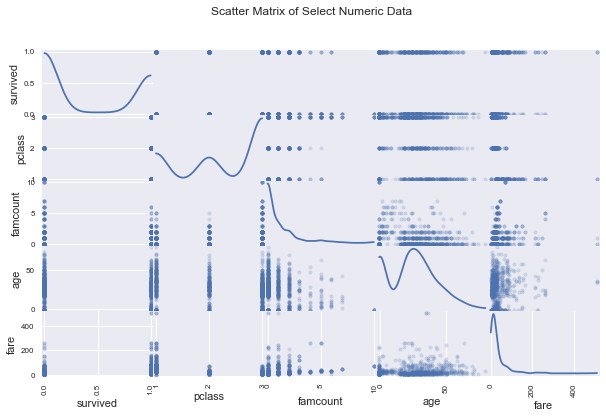

In [448]:
## What is missing?
info = pd.DataFrame()
info['missing_count'] = df.isnull().sum()
info['missing_percent'] = 100*df.isnull().sum()/len(df)
info['dtype'] = df.dtypes
info = info.join(df.describe().transpose())
print("Raw Titanic Data Summary Information\n",info)

print("\n\n{} passengers ages are estimated, not known exactly".format(len(df[df.Age.round() != df.Age][df.Age.notnull()])))

print("\nPassenger information sorted by fare:\n",df.sort_values(by='Fare').head(10))
## Lowercase columns
df.columns = [col.lower() for col in df.columns]

## Split out family name
df['famname'] = df.name.apply(lambda n: n.split(',')[0])

## Immediate family member count
df['famcount'] = df.apply(lambda row: row['sibsp'] + row['parch'], axis=1)

## Replace NaN Cabin and Age Assignments
df.loc[df.cabin.isnull(), 'cabin'] = "Unknown"
df.loc[df.age.isnull(), 'age'] = -1


## reorder columns 
df = df[['passengerid', 'survived', 'pclass', 'famname', 'famcount', 'sibsp', 'parch', 'name', 'sex', 'age', 'ticket', 'fare', 'cabin', 'embarked']]

## Super scatter matrix plot
scatter_matrix(df[['survived','pclass','famcount','age','fare','embarked']],alpha=0.2, figsize=(10, 6), diagonal='kde')
plt.suptitle("Scatter Matrix of Select Numeric Data")

## Initial scatter matrix plot
df.head()



### 3. Question Time
Some questions that I have about the Titanic dataset are:
0. How did travel class affect who survived?
0. How did gender affect who survived?
0. How did age affect who survived? 
0. Were families more likely to survive or die together? 
0. Did cabin placement have an effect on who survived?

### Exploration 1: Class Effects

#### Class Surviveability
Immediately, it is apparant that **first class passengers were more likely to survive the sinking**. The effect becomes more pronounced when examining survival percentages, where we see that over **60% of first class passengers survived** versus just **47% of second and 24% of third class passengers**. 

Surviveability percentage:        
	First Class: 62.96        
	Second Class: 47.28        
	Third Class: 24.24


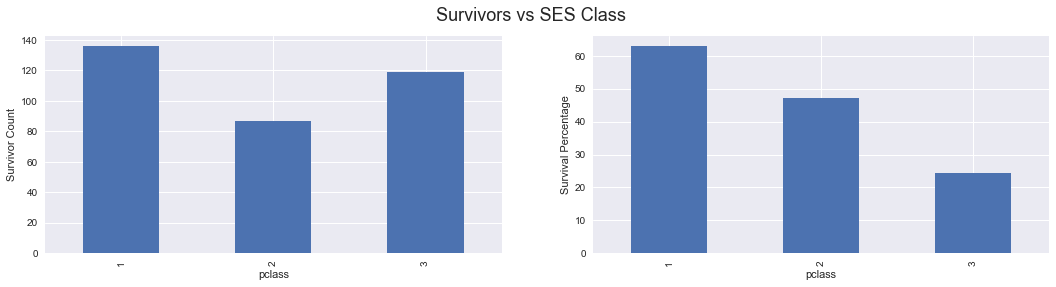

In [451]:
fig = plt.figure()
fig.suptitle("Survivors vs SES Class", fontsize=18)

## Raw surviveability counts
ax1 = fig.add_subplot(121)
df.groupby('pclass').survived.sum().plot(ax=ax1,kind='bar')
ax1.set_ylabel('Survivor Count')

## Percentage Survived
percentages = (df.groupby('pclass').survived.sum()/df.groupby('pclass').survived.agg(len)*100)
ax2 = fig.add_subplot(122)
percentages.plot(kind='bar', ax=ax2)
ax2.set_ylabel('Survival Percentage')

print(f"Surviveability percentage:\
        \n\tFirst Class: {percentages[1]:3.2f}\
        \n\tSecond Class: {percentages[2]:3.2f}\
        \n\tThird Class: {percentages[3]:3.2f}")

### Exploration: Class and Gender
First class females were by far most prominantly represented among the survivors. Less than **5% of the first class women** actually perished in the sinking. Compare that percentage with **first class men, of which 63% perished**. 

Across the board, it seems that women were more likely to survive the sinking than men. **Regardless of class, women reported the highest survival rates**.

Lower-class males accounted for the highest death percentages among Titanic patrons, with over **90% of both 2nd and 3rd class male** passengers perishing.

From the raw death count bar chart, **3rd class males represent a majority of those who died**. Over half of all deaths belonged to that group.




Of the 549 deaths reported, 300 (54.64%) belonged to 3rd class males


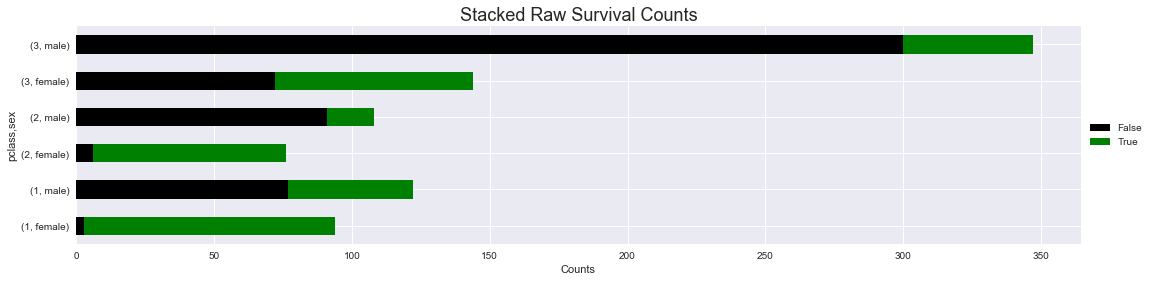

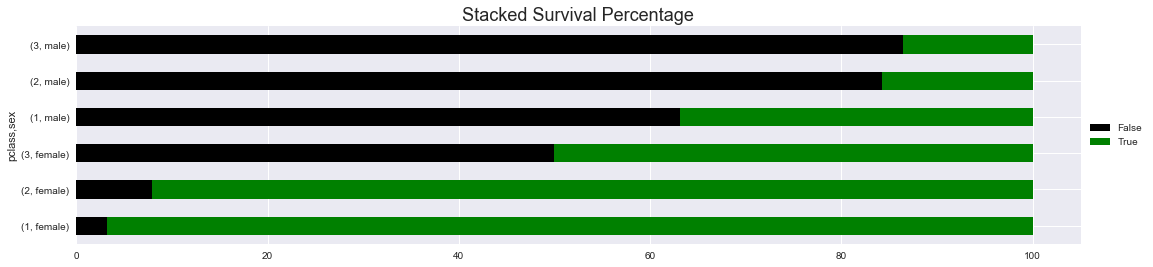

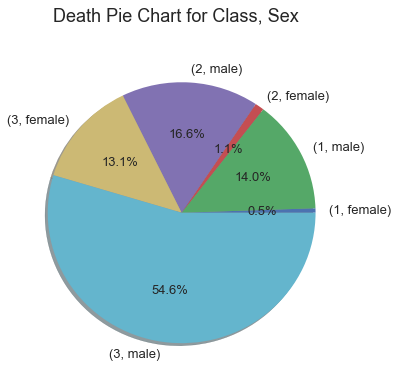

In [455]:
## Crosstab of gender and class
survived = pd.crosstab([df.pclass, df.sex], df.survived.astype('bool'))

## Raw Counts
fig, ax = plt.subplots()
survived.plot(ax=ax, kind='barh', color=['black','green'], stacked=True, legend=["Perished","Survived"])
ax.set_xlabel("Counts"); ax.set_title("Stacked Raw Survival Counts", fontsize=18)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Relative Surviveability                                                         | Kinda odd, 'True' is the column we're 
#                                                                                     sorting by to get ordered survivals 
sur_percentages = (survived.div(survived.sum(axis=1), axis=0)*100).sort_values(by=True,ascending=False)
# print(f"Survival percentages: \n\t{sur_percentages}")
fig,ax = plt.subplots()
sur_percentages.plot(ax=ax, kind='barh', color=['black','green'], stacked=True, legend=["Perished","Survived"])
ax.set_title("Stacked Survival Percentage", fontsize=18); ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Deaths
deaths = survived[False]
death_percentages = deaths/deaths.sum()
fig = plt.figure(figsize=(6,6))
fig.suptitle("Death Pie Chart for Class, Sex", fontsize=18)
ax = deaths.plot(kind='pie',autopct='%1.1f%%', startangle=0, fontsize=13, shadow=True)
ax.set_ylabel("")
print(f"\n\nOf the {deaths.sum()} deaths reported, {deaths.loc[3,'male']} ({100*death_percentages.loc[3,'male']:3.2f}%) belonged to 3rd class males")




### Exploration: Age

Overall, the passenger age distribution looks to have a slight positive skew, offset by a decent number of young children. Passenger **mean (29.6 years)** and **median (28 years)** ages show that a large number of passengers were late-20s. 

When viewed by class, first class passengers tended to be older and more uniformly distributed, while 2nd and 3rd class distributions showed a bump of younger aged passengers, which could indicate that these classes were more likely to travel with families. 

**Note** that undefined ages are identified as being less than 0, so only known ages (>0) are to be examined

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

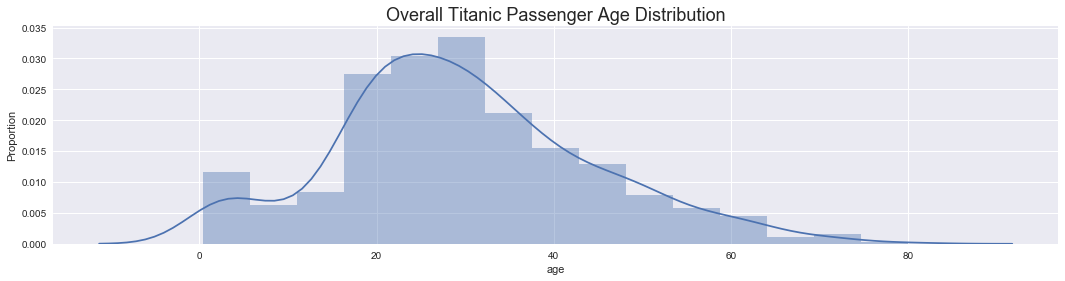

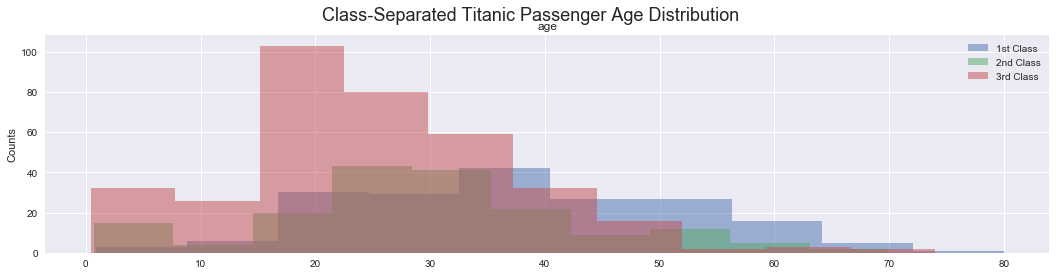

In [460]:
## Consider only passengers whose ages are known
dfa = df[df.age > 0].copy()
fig = plt.figure()
sns.distplot(dfa.age, bins=15)
fig.axes[0].set_title("Overall Titanic Passenger Age Distribution", fontsize=18); fig.axes[0].set_ylabel("Proportion")

fig,ax = plt.subplots()
fig.suptitle("Class-Separated Titanic Passenger Age Distribution", fontsize=18); ax.set_ylabel("Counts")
dfa.groupby('pclass').hist('age',ax=ax,alpha=0.5); ax.legend(["1st Class", "2nd Class","3rd Class"])
dfa.age.describe()

#### Age Groups
I define the following age groups for convenience of analysis:
* *Children* ages 0-10
* *Teenagers* ages 10-20
* *Adults* ages 20-40
* *Middle aged* ages 60-60
* *Elderly* ages 60-100

##### Age Surviveability 
Although children make up only **8.9% of the population**, they account for the highest survival rate among passengers with **59.4% of children surviving the sinking**.  Next, **teenagers, adults, and the middle aged passengers** all had similar survival rates **40%**, while the **elderly showed lowest** survival rates of just **22.7%**. While common practice typically places children ahead of older age groups when it comes to filling life boat seats on a sinking ship (which could account for the higher survival rate of children), we have to keep in mind that the skinking and time spent awaiting rescue was a physically tramatic event. It is possible that the survival rates below are attributed to the ability to physically survive the event, instead of preferential life boat assignemnts.

##### Class Implications
In the age/class bar chart below, we can see that the class still playes a big role in surviveability percentages. With the exception of **2nd class children**, the entire bottom portion of the chart (indicating high survival percentages) is **dominated by first class passengers**. From the chart above, there were relatively few first class children (just 3 in fact), so a single mishap causing the death of a first class child has a large effect on survival percentages for the class/age group. **One 1st class child and zero 2nd class children perished** in the sinking. 

The other age/class group that did not follow the class-first trend were the **first class elderly** passengers. They exhibited the 3rd lowest survival percentage of **21.4%**, followed by **3rd class elderly at 20%** and **3rd class middle aged survival rates at just 5.7%**. Again, these low survival rates could be due to the strenuous nature of the debarkation and wait for rescue, or age-biased life seat allocation. Any conclusions therein would just be extrapolation however. 

Population Age Group percentages:
 adult          53.921569
middle-aged    17.927171
teens          16.106443
children        8.963585
elderly         3.081232
Name: agegroup, dtype: float64


Survival percentages:
 adult          39.740260
middle-aged    39.062500
teens          38.260870
children       59.375000
elderly        22.727273
Name: agegroup, dtype: float64


Age Grouped Survival Percentages by Class
 survived                False       True 
agegroup    pclass                       
children    2        0.000000  100.000000
teens       1       16.666667   83.333333
adult       1       25.842697   74.157303
children    1       33.333333   66.666667
middle-aged 1       41.935484   58.064516
teens       2       50.000000   50.000000
children    3       56.818182   43.181818
adult       2       57.692308   42.307692
middle-aged 2       61.290323   38.709677
elderly     2       66.666667   33.333333
teens       3       74.683544   25.316456
adult       3       77.604167   22.39

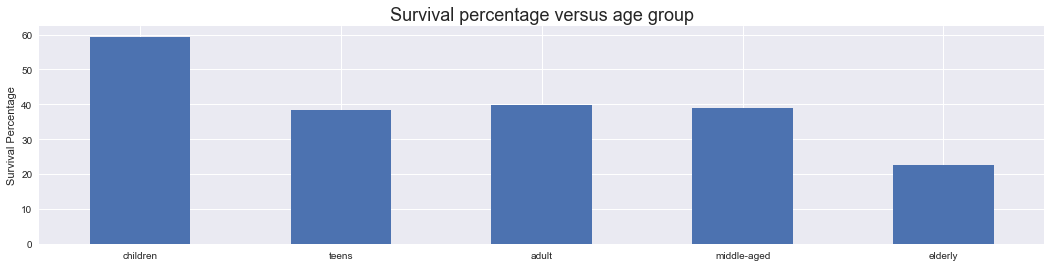

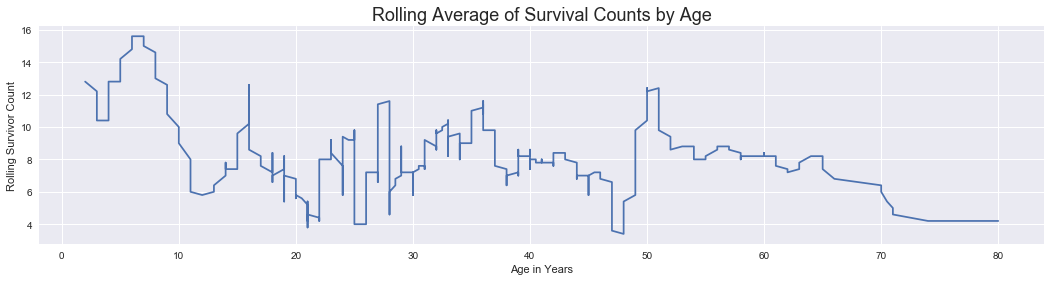

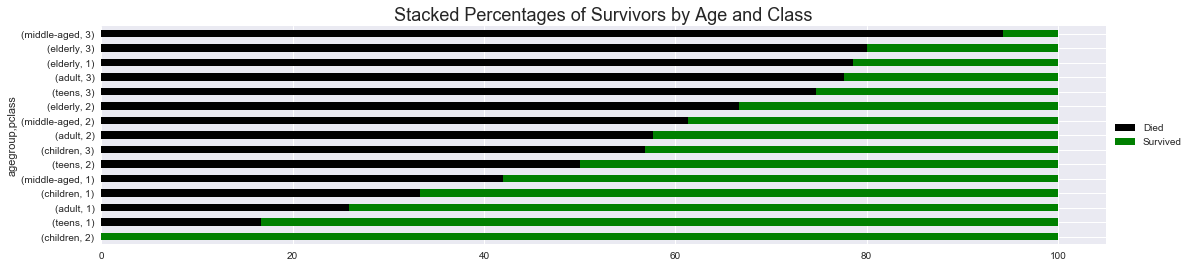

In [462]:
## Group passengers into different age categories
dfa['agegroup'] = pd.cut(dfa['age'], [0,10,20,40,60,100], labels=['children','teens','adult','middle-aged','elderly']) #*1
dfa.sort_values(by='age',inplace=True)
age_percentages = (100*dfa.agegroup.value_counts()/len(dfa))
print("Population Age Group percentages:\n", age_percentages)


## Agegroup survival 
fig, ax = plt.subplots()
survived = dfa[dfa.survived==1]
sur_percentages = (100*survived.agegroup.value_counts()/dfa.agegroup.value_counts())
sur_percentages.reindex(['children','teens','adult','middle-aged','elderly']).plot(kind='bar') #*2
ax.set_title("Survival percentage versus age group", fontsize=18); ax.set_ylabel("Survival Percentage"); ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
print("\n\nSurvival percentages:\n", sur_percentages)

fig,ax = plt.subplots()
rsum = dfa.survived.rolling(window=10).sum()

ax.plot(dfa.age,dfa.survived.rolling(window=20).sum().rolling(window=5).mean())
ax.set_title("Rolling Average of Survival Counts by Age", fontsize=18); ax.set_ylabel('Rolling Survivor Count'); ax.set_xlabel('Age in Years')

## Survival Percentages
ages = pd.crosstab([dfa.agegroup, df.pclass], df.survived.astype('bool'))
fig, ax = plt.subplots()
age_sur = (ages.div(ages.sum(axis=1), axis=0)*100).sort_values(by=True,ascending=False)
age_sur.plot(ax=ax, kind='barh', color=['black','green'], stacked=True)
ax.set_title("Stacked Percentages of Survivors by Agegroup and Class", fontsize=18)
_=ax.legend(['Died','Survived'],loc='center left', bbox_to_anchor=(1, 0.5))
print("\n\nAge Grouped Survival Percentages by Class\n",age_sur)


#*1 http://chrisalbon.com/python/pandas_binning_data.html
#*2 http://stackoverflow.com/questions/32015669/change-order-of-columns-in-stacked-bar-plot


### Exploration: Families
Here, I take a cursory look at families (parent(s) + children) traveling on the Titanic. A goup of passengers is considered a family if:
* Passengers share a last name
* Passengers have at least one parent/child on board

From the age exploration above, we know that 2nd and 3rd class adults had lower survival rates (42.3% and 22.4%, respectively) when compared to 1st class adults (75.2%). Below, I examined how many single adults (passengers age 20+ with no siblings/spouses/children/parents) survived when compared to adults that were traveling with family members. I found that only **32.8% of single adults** survived the sinking, vs **52% of adults traveling in a family**.  

Next, I wanted to see how survival correlated adult males traveling alone or with a family. So far, adult males had low survival rates when compared to other sex/age groups. The findings here are perhaps the most telling so far. For example, among 2nd class males, only **7% of single men** survived, versus **65% of men with families on board**.

While 1st class passengers in general had higher survival percentages than 2nd or 3rd class ones did, nearly half (47.1%) of the families on board were 3rd class passengers. This could indicate that (as dramatized by the movie Titanic), while children were given precidence for seats on the life boats, officials might have been hesitant to split up accompanying parents and allowed them to take a seat that they otherwise would not have been given to an adult.

Single adults had a 32.84% survival rate, while family member adults had a 52.00% survival rate

Single 1 class adult males had a 37.04% survival rate, while 1 class family member adults had a 64.10% survival rate
1 class families represent 30.23% of all families on board
Statistically, this difference has a 77.31% chance of occuring by chance

Single 2 class adult males had a 7.41% survival rate, while 2 class family member adults had a 65.52% survival rate
2 class families represent 22.60% of all families on board
Statistically, this difference has a 54.36% chance of occuring by chance

Single 3 class adult males had a 14.77% survival rate, while 3 class family member adults had a 25.00% survival rate
3 class families represent 47.18% of all families on board
Statistically, this difference has a 10.72% chance of occuring by chance


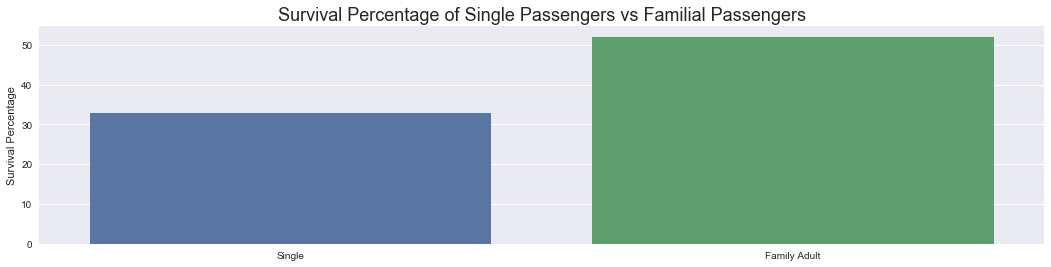

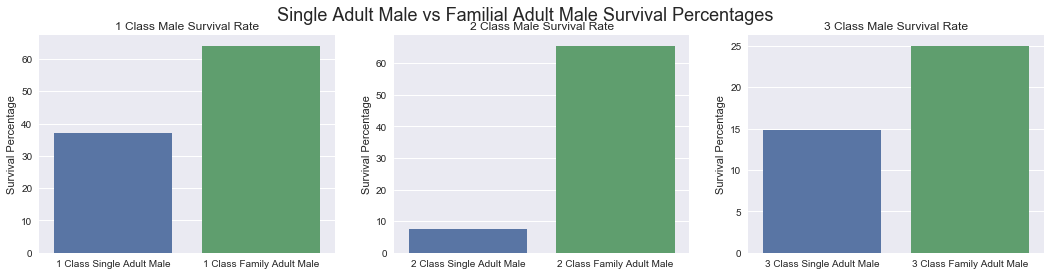

In [465]:
families = df.query('parch > 0').sort_values(by='famname')
families.head()

## First order search, are adults with a family more likely to survive?
single_sur = df.query('famcount == 0 and age > 20').survived.sum()/len(df.query('famcount == 0 and age > 20'))
fam_sur = families.query('age > 20').survived.sum()/len(families.query('age > 20'))
ax = sns.barplot(x=['Single','Family Adult'], y=[100*single_sur, 100*fam_sur])
ax.set_ylabel("Survival Percentage"); ax.set_title("Survival Percentage of Single Passengers vs Familial Passengers", fontsize=18)
print(f"Single adults had a {single_sur*100:3.2f}% survival rate, while family member adults had a {fam_sur*100:3.2f}% survival rate")

plt.figure()
plt.suptitle("Single Adult Male vs Familial Adult Male Survival Percentages", fontsize=18)
for pclass in [1,2,3]:
    plt.subplot(1,3, pclass)
    single_sur_ = df.query(f'famcount == 0 and age > 20 and pclass=={pclass} and  sex=="male"').survived.sum()/len(df.query(f'famcount == 0 and age > 20 and pclass=={pclass} and sex=="male"'))
    fam_sur_ = families.query(f'age > 20 and pclass=={pclass}').survived.sum()/len(families.query(f'age > 20 and pclass=={pclass}'))
    ax = sns.barplot(x=[f'{pclass} Class Single Adult Male',f'{pclass} Class Family Adult Male'], y=[100*single_sur_, 100*fam_sur_])
    ax.set_ylabel("Survival Percentage"); ax.set_title(f"{pclass} Class Male Survival Rate")
    print(f"\nSingle {pclass} class adult males had a {single_sur_*100:3.2f}% survival rate, while {pclass} class family member adults had a {fam_sur_*100:3.2f}% survival rate")
    print("{} class families represent {:3.2f}% of all families on board".format(pclass, 100*len( df.query(f'pclass == {pclass} and famcount > 0'))/len(df.query('famcount > 0'))))
    
    ## T-Test 
    t,p = st.ttest_ind(df.query(f'famcount == 0 and age > 20 and pclass=={pclass} and  sex=="male"').survived,df.query(f'famcount > 0 and age > 20 and pclass=={pclass} and  sex=="male"').survived)
    print(f"Statistically, this difference has a {100*p:3.2f}% chance of occuring by chance")


### Exploration: Cabin
The last exploration I wanted to perform was one to see if cabin location played a role in passenger survival rates.

From the diagram below<sup>1</sup>, cabin sections are organized alphabetically, starting at the top of the ship. Section *A* is the highest section, *B* one below, and so on, until section *G*, which is in the lower section of the ship. 

First clas spassengers were assigned to sections *B* and *C*, *D*, and *E*. From earlier explorations, more first class passengers survived the sinking relative to lower class passengers. Since their cabins were located higher on the ship, nearer the life boats and farther from where the ship struck the iceberg, their survival could be attributed to pure logistics, instead of class bias. However, since it took approximately 2.5 hours for the ship to sink<sup>2</sup>, some level of organization and control was likely enacted in getting passengers into life boats.

Below, survival percentages are visualized with respect to cabin, and cabin + gender. Cabins *B* *D* and *E* eash showed about 75% survival rates, higher than the any other cabins. Perhaps most telling though, is the fact that in the second chart, 100% of ticketed women in cabins *A*, *B*, *D*, and *F* survived the event. Some cabin *C* and *E* women perished, but still survived at a rate of over 85%. Plausibly, this could indicate that there was indeed a level of organization to getting passengers into life boats. There was enough time to prioritize the first 6 cabin sections to get women on board first. There likely weren't enough life boats or time to organize section *G* passengers. 

![Titanic](http://1.bp.blogspot.com/-E4r73C2lSyw/UFDGu4_9jBI/AAAAAAAAANc/ao7fY_fLotQ/s1600/TITANIC.jpg)

*1 http://1.bp.blogspot.com/-E4r73C2lSyw/UFDGu4_9jBI/AAAAAAAAANc/ao7fY_fLotQ/s1600/TITANIC.jpg
*2 http://www.titanicfacts.net/titanic-sinking.html

Survival percentages as organized by cabin section:
 section
A    46.666667
B    74.468085
C    59.322034
D    75.757576
E    75.000000
F    61.538462
G    50.000000
T     0.000000
dtype: float64


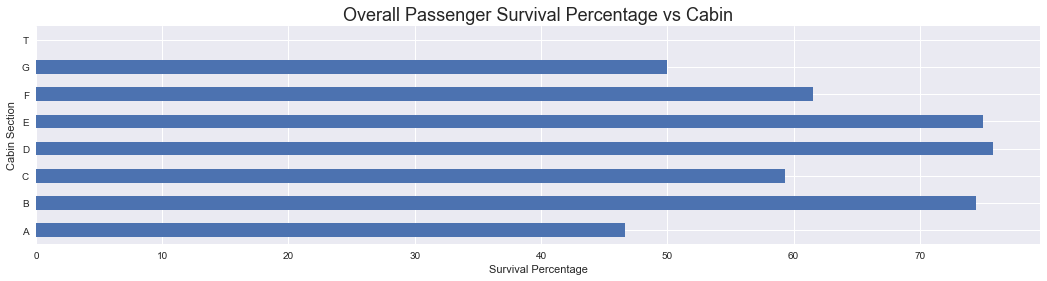

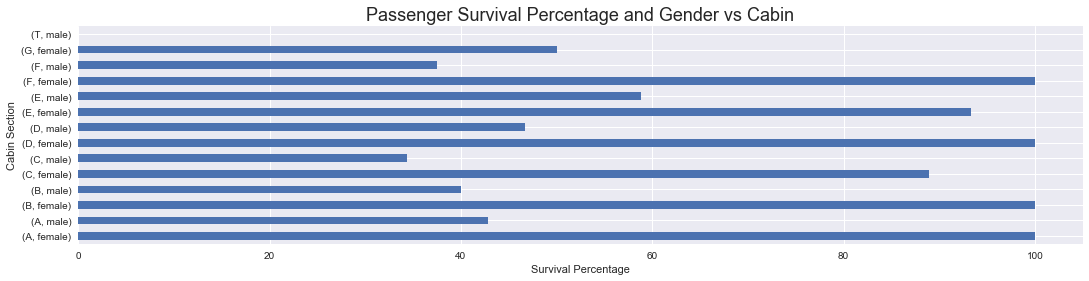

In [467]:
## Examine only passengers with known cabins, extract "section"
dfc = df[df.cabin != "Unknown"].sort_values(by='cabin').copy()
dfc['section'] = dfc.apply(lambda row:row.cabin[0], axis=1)

## Plots
sur = pd.crosstab([dfc.section], dfc.survived.astype('bool'))
print("Survival percentages as organized by cabin section:\n",(100*sur[True]/sur.sum(axis=1)))
ax=(100*sur[True]/sur.sum(axis=1)).plot(kind='barh',stacked=True)
ax.set_xlabel("Survival Percentage"); ax.set_ylabel("Cabin Section"); ax.set_title("Overall Passenger Survival Percentage vs Cabin Section", fontsize=18)

plt.figure()
sur = pd.crosstab([dfc.section, dfc.sex], dfc.survived.astype('bool'))
ax=(100*sur[True]/sur.sum(axis=1)).plot(kind='barh',stacked=True)
ax.set_xlabel("Survival Percentage"); ax.set_ylabel("Cabin Section"); _=ax.set_title("Passenger Survival Percentage and Gender vs Cabin Section", fontsize=18)

## Conclusions
Throughout the investiation, there were three dominant attributes that correlated with passenger survival. 
0. Gender
0. Age
0. Class

The age-old addage of "women and children first" seems to have held true in the Titanic sinking. Across all classes, women survived at a higher rate than men did. Children (ages 0-10), despite a majority of them traveling in 2nd or 3rd class, also exhibited higher survival percentages than the older age members. 1st class passengers generally survived at higher rates than lower class ones of the same age and gender. This could indicate a preference for the 1st class passengers when it came to assigning seats on life boats, however we also saw that 1st class passengers resided in the higher decks of the ship. Higher decks were closer to the life boats and logistically could have given these passengers a better chance at getting to and securing a seat on the life boats.

An interesting exception to the observations above was found in a correlation between adult males traveling with family members. Adult men traveling with their families exhibeted higher survival percentages than their single counterparts.

### Limitations
As with any limited dataset, there are limitations on the analysis and drawable conclusions therein. 
* While most passenger attributes were provided for a majority of the population, nearly 80% of the **cabin** information was missing. The **section** analysis took another step to approximate cabin location on the ship. We must take into account that by creating an approximation of an already ill-known value, the conclusions from that analysis are at best a rough estimation of the population. I would use any conclusions here as a supplimentary finding, and not a stand-alone statement.
    * Additionally, I was unable to identify where the **T** sections resided on the ship. There was a single passenger whose cabin was identified (and section inferred) as *T*. That cabin was included in visualizations and analysis but it's actual location on the ship and valididty are questionable. 
* The **age** attribute was available for most (81%) passengers, but 25 of which were still just guesses. We have no information as to the validity of said guesses. I chose to include the guesses in analysis and treat them as if they were fully accurate because of the granularity of age based explorations. Additionally, I was not able to discern a difference in age-based behaviors with or without the guessed ages, so made the decision to keep them in the analysis. 
* The *Death Mechanism* was not accounted for in **survival** attribute for columns. It would be helpful to know how a passenger died. I.E. if they sunk with the ship, drowned after jumping overboard, or took sick on a life boat. Such information might have helped isolate more definitive factors that lead to a passenger's survival or death on board. 
* *When a survivor boarded a life boat* would be a helpful metric as well, as it may allow us to isolate whether location/logistics played a role in doling out seats on the life boats versus a clear preference for class/gender/age given by the crew. For example, the fact that 1st class passengers exhibited higher survival percentages could be wholly explained by the fact that they were traveling in rooms that were simply closest to the main deck where the life boats were boarded. 
* The **family** exploration above made some assumptions about family members having the same last name, and assumed that family members were all known and accounted for in the dataset. The former is a fair assumption, though it is likely that there were a few families with different last names, or multiple people with the same last name. Had cabin information been more filled in, that may have given another metric to use to isolate families traveling together and made the isolation thereof more accurate. 

### Disclaimer
It is important to note that all findings and conclusions found above are pure observations of correlation, and do not imply causation. Conclusions cannot be drawn between passenger attributes and thier personal liklihood to survive the sinking. 